# ЗАНЯТИЕ 2.5. АНСАМБЛИ МОДЕЛЕЙ

Загружаем библиотеки

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [18]:
data = pd.read_csv('train.csv')

Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

Разбиение на обучение и hold-out тест 70/30. Данных достаточно много, поэтому можно принебречь честной кросс-валидацией и оценивать модель на тесте

In [20]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

## Первичный анализ

Размер датасета

In [5]:
data.shape

(22865, 133)

Распределение значений таргета (event rate)

In [6]:
data.target.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [62]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [22]:
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression

## Композиции моделей одного семейства

### Будем использовать решающие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> отличный выбор для построения композиций

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
3. Создаем дамми-переменные для категорий

In [23]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [24]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Считаем ROC AUC

In [25]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Предсказываем вероятность класса 1 и считаем ROC AUC

Train:
ROC AUC: 0.8585
Test:
ROC AUC: 0.6478


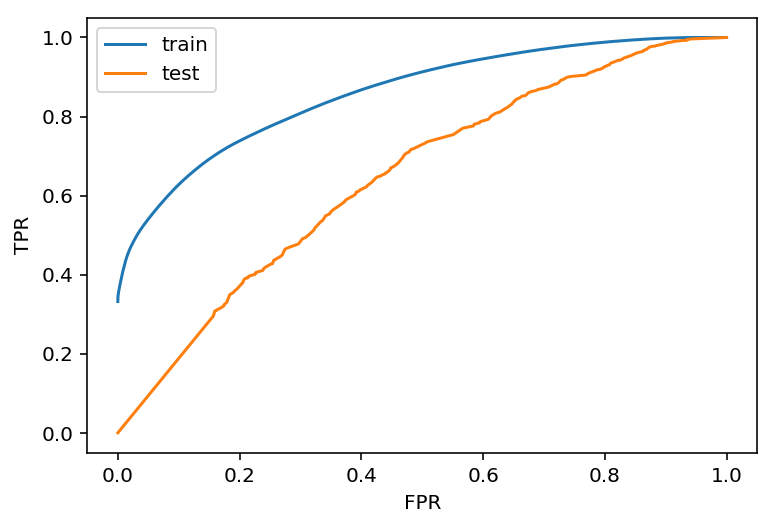

In [26]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

### Бэггинг

Самостоятельная реализация через цикл и numpy

In [27]:
BAGGING_ITERS = 20

n_rows = len(X_train)

y_pred_test = np.zeros_like(y_test, dtype=float)
y_pred_train = np.zeros_like(y_train, dtype=float)
for it in tqdm.trange(BAGGING_ITERS):
    bag_index = np.random.choice(np.arange(n_rows), n_rows)

    clf_tree.fit(X_train.iloc[bag_index], y_train.iloc[bag_index])
    
    y_pred_test += clf_tree.predict_proba(X_test)[:, 1]
    y_pred_train += clf_tree.predict_proba(X_train)[:, 1]
    
y_pred_test /= BAGGING_ITERS
y_pred_train /= BAGGING_ITERS

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


Train:
ROC AUC: 0.9211
Test:
ROC AUC: 0.7151


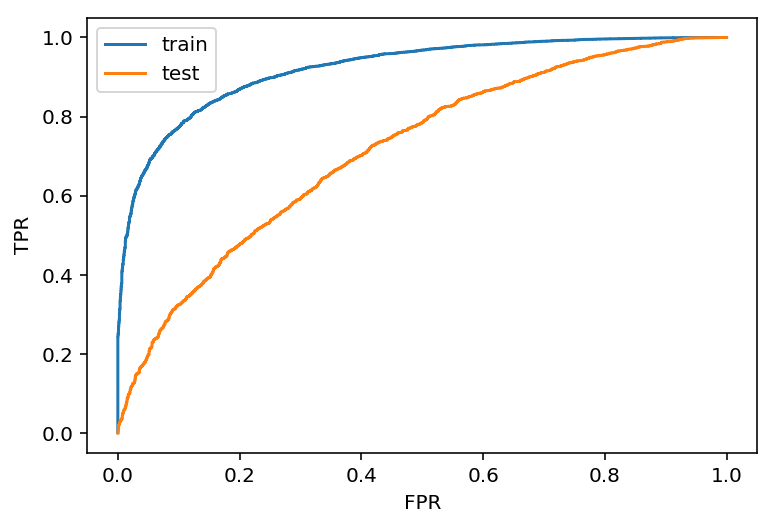

In [28]:
print('Train:')
calc_auc(y_train, y_pred_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

#### Другой способ

Используем готовый алгоритм из sklearn

In [30]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Train:
ROC AUC: 0.8908
Test:
ROC AUC: 0.7178


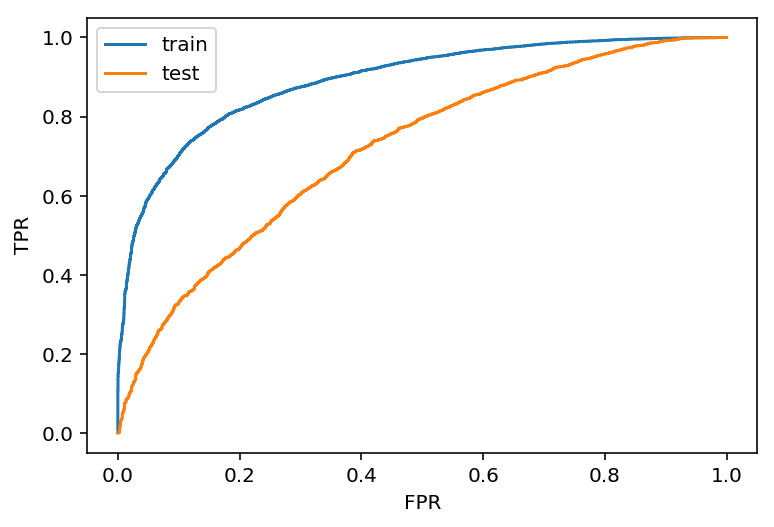

In [31]:
y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 2. Случайный лес

Бэггинг + случайные подпространства = случайный лес

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [74]:
'минимальное число объектов в листе'.upper()

'МИНИМАЛЬНОЕ ЧИСЛО ОБЪЕКТОВ В ЛИСТЕ'

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=20, max_features=0.8, n_jobs=-1)

clf_rf.fit(X_train, y_train)    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train:
ROC AUC: 0.8993
Test:
ROC AUC: 0.7244


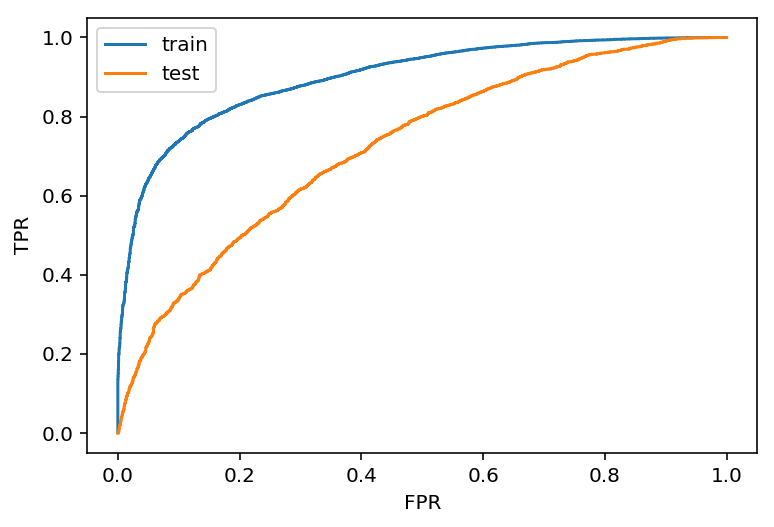

In [40]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [35]:
imp = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
imp.sort_values(ascending=False)

v50       0.271222
v66_C     0.039560
v21       0.033606
v12       0.029635
v110_A    0.029265
v14       0.024450
v34       0.024064
v114      0.023000
v40       0.022769
v66_B     0.021312
v10       0.017670
v47_C     0.016266
v31_A     0.016227
v110_B    0.013127
v66_A     0.011538
v120      0.005773
v98       0.005578
v126      0.005479
v115      0.005477
v90       0.005240
v6        0.005141
v9        0.005119
v57       0.005062
v80       0.005006
v37       0.004999
v129      0.004930
v81       0.004903
v127      0.004854
v97       0.004783
v78       0.004738
            ...   
v30_F     0.000045
v112_T    0.000043
v112_H    0.000040
v3_C      0.000014
v112_K    0.000012
v3_B      0.000000
v47_A     0.000000
v112_S    0.000000
v107_G    0.000000
v112_G    0.000000
v74_C     0.000000
v30_E     0.000000
v112_B    0.000000
v75_A     0.000000
v112_V    0.000000
v30_B     0.000000
v79_R     0.000000
v3_A      0.000000
v91_D     0.000000
v47_B     0.000000
v75_C     0.000000
v112_M    0.

# Часть 3. Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и логистическую регрессию

**Создаем признаки для лог регрессии**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаем дамми-переменные для категорий
4. Нормируем признаки

In [36]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

Обучим логистическую регрессию

In [37]:
clf_lr = LogisticRegression(penalty='l1', C=0.1)

clf_lr.fit(X_train_lin, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Train:
ROC AUC: 0.7324
Test:
ROC AUC: 0.7240


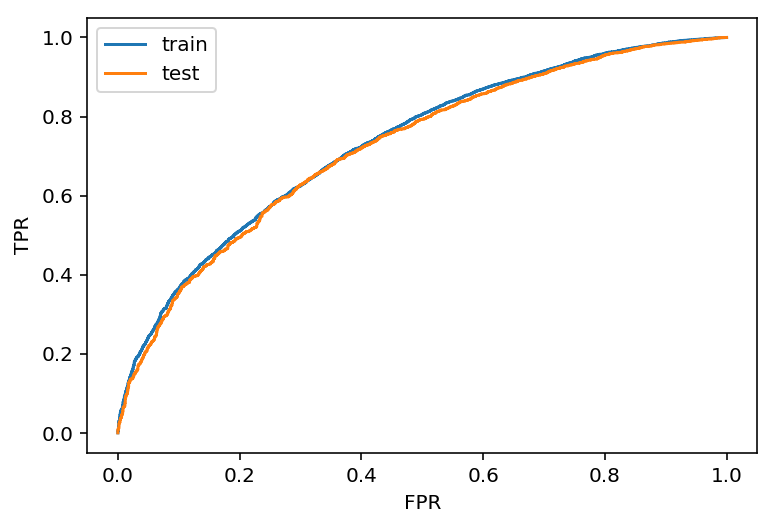

In [38]:
y_pred_lin_test = clf_lr.predict_proba(X_test_lin)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train_lin)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_lin_test, 'test')
plt.legend();

Будем строить линейную комбинацию вида

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

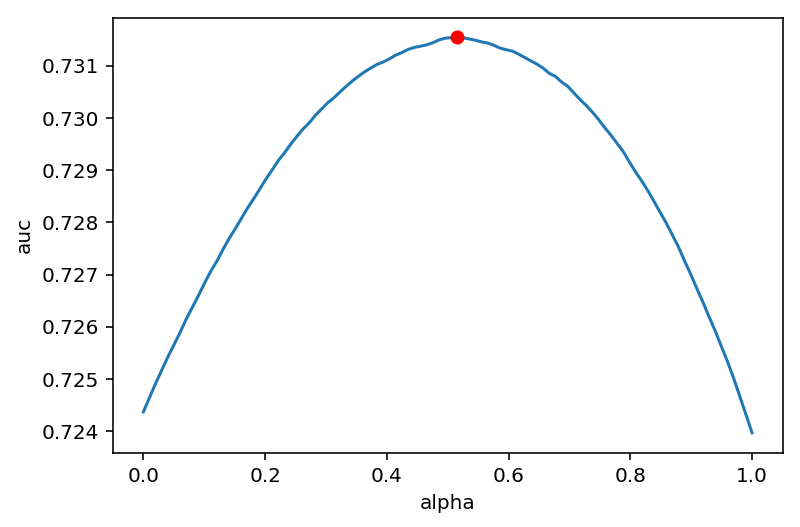

In [41]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_rf_test
    aucs.append(calc_auc(y_test, y_pred_weight, prin=False))
aucs = np.array(aucs)    

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_rf_test

Сравним 3 метода (приблизим график ROC кривой, чтобы увидеть разницу)

Weighted:
ROC AUC: 0.7315
Log regression:
ROC AUC: 0.7240
Random forest:
ROC AUC: 0.7244


(0.5, 0.8)

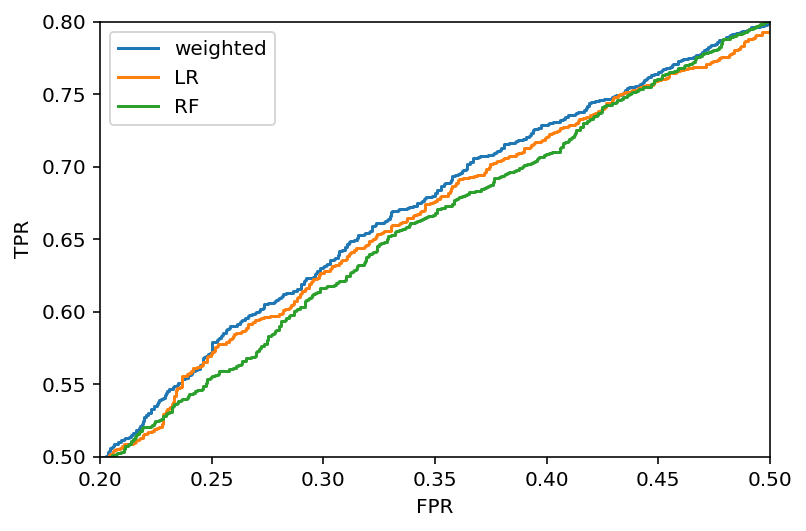

In [70]:
print('Weighted:')
calc_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
calc_auc(y_test, y_pred_lin_test, 'LR')
print('Random forest:')
calc_auc(y_test, y_pred_rf_test, 'RF')
plt.legend();
plt.xlim(0.2, 0.5)
plt.ylim(0.5, 0.8)

### Стэкинг

#### Средние значения таргета

Создадим новые признаки, на основе категориальных переменных. Каждому уникальному значению $V$ переменной $X_i$ сопоставим среднее значение таргета среди всех объектов, у которых переменная $X_i$ принимает значение $V$ 

Новый признак со средними значением таргета в категории можно считать за предсказание вер-ти класса 1 простого классификатора "усреднения"

Опишем класс этого классификатора

In [43]:
class MeanClassifier():
    def __init__(self, col):
        self._col = col
        
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()

    def predict_proba(self, X):
        new_feature = X[self._col].astype(str)\
            .map(self._means.to_dict())\
            .fillna(self._y_mean)
        return np.stack([1-new_feature, new_feature], axis=1)

Делаем предсказания по фолдам кросс-валидации. **Главное не допустить утечки информации!**

Опишем функцию для стекинга

In [44]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

### Стекинг нескольких моделей
0. Средние значения
1. Random Forest
2. Log reg
3. SVM

Посмотрим, какое качество дает линейный SVM

для совместимости с общим кодом стекинга немного модифицируем класс SVM

Train:
ROC AUC: 0.7324
Test:
ROC AUC: 0.7240


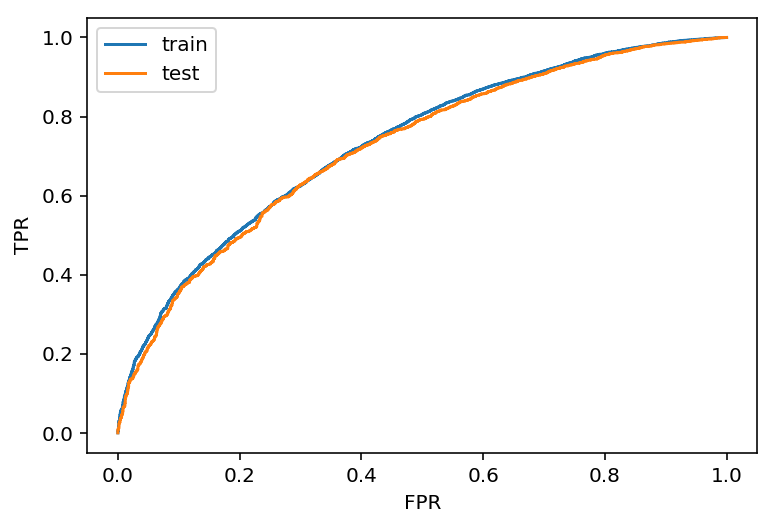

In [50]:
from sklearn.svm import LinearSVC

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

class SVMWrapper(LinearSVC):
    def predict_proba(self, X):
        df = norm(self.decision_function(X))
        return np.stack([1-df, df], axis=1)

clf_svm = SVMWrapper(C=0.001)    
clf_svm.fit(X_train_lin, y_train)

y_pred_svm_test = clf_svm.predict_proba(X_test_lin)[:, 1]
y_pred_svm_train = clf_svm.predict_proba(X_train_lin)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_lin_test, 'test')
plt.legend();

Теперь получим мета признаки для 3х моделей:
* SVM
* Logreg
* Random Forest
и средних значений по каждой категориальной переменной

In [52]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('mean features...')
for c in cat_nunique.index.tolist():
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, y_train, d_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('mean_pred_{}'.format(c))

print('SVM features...')
meta_tr, meta_te = get_meta_features(clf_svm, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svm_pred')

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

mean features...
SVM features...
LR features...
RF features...


In [56]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стэкинг мета-признаков с помощью LR

Используем регуляризованную лог регрессию в качестве алгоритма второго уровня

In [57]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1)

clf_lr_meta.fit(X_meta_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

ROC AUC: 0.7365


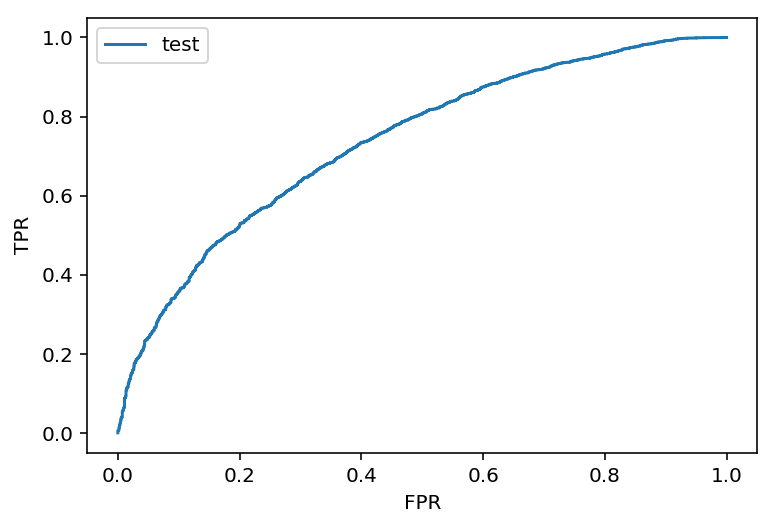

In [58]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]

calc_auc(y_test, y_pred_meta_test, 'test')
plt.legend();

#### Посмотрим на коэффициенты объединяющей линейной модели

Получим интерпретацию общей модели

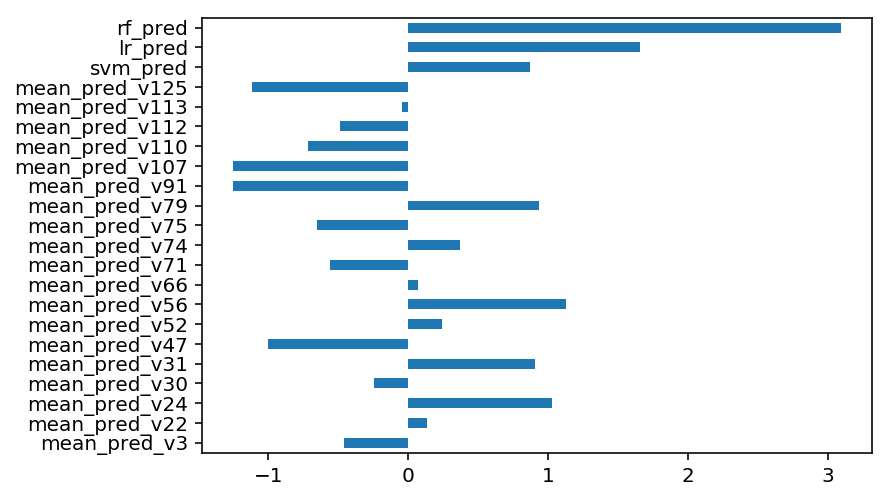

In [59]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

# Домашняя работа

#### Простая
1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

#### Средняя
0. Все то же, что и в части 1, плюс:
1. Попробовать другие оценки важности переменных, например Boruta
http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/#comments
3. Изучить extremely randomized trees (ExtraTreesRegressor в sklearn), сравнить с Random Forest
4. Проводить настройку гиперпараметров для моделей первого уровня в стекинге (перебирать руками и смотреть на CV или по сетке: GridSearchCV, RandomizedSearchCV)
5. Попробовать другие алгоритмы второго уровня
6. Сделать сабмиты на kaggle (минимум 3: отдельные модели vs стекинг), сравнить качество на локальной валидации и на leaderboard
7. В качестве решения:
    * Jupyter notebook с кодом, комментариями и графиками
    * сабмит на kaggle (ник на leaderboard)